In [19]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

seed = np.random.seed(69)

In [12]:
input_file_path = 'SMI_log_returns(10Nov).csv'
new_df = pd.read_csv(input_file_path)

new_df

,Date,Close,log_returns,log_prices
0,2024-11-08,11797.72,NaN,9.375662
1,2024-11-07,11917.00,0.010060,9.385721
2,2024-11-06,11847.29,-0.005867,9.379854
3,2024-11-05,11866.01,0.001579,9.381433
4,2024-11-04,11896.94,0.002603,9.384037
...,...,...,...,...
717,2022-01-07,12797.94,0.015798,9.457039
718,2022-01-06,12792.28,-0.000442,9.456597
719,2022-01-05,12906.37,0.008879,9.465476
720,2022-01-04,12900.97,-0.000418,9.465058


In [17]:
# Geometric Brownian Motion
# S(t) = S(0) * exp((r - 0.5 * sigma^2) * t + sigma * W(t))
# Where:
# S(t) = Stock price at time t
# S(0) = Initial stock price
# r = Drift rate of the stock
# sigma = Volatility of the stock
# t = Time
# W(t) = Wiener process

barrier_price = 6566.9596
T = 252
dt= 1/T

mean = new_df['log_returns'].mean()/dt
sigma = new_df['log_returns'].std()/ np.sqrt(dt)
S_0 = 11130.44
r = 0.01 # 1% - Based on historical data
Nsim = 10000 # Number of simulations
N = 211 # 211 trading days between 15th October 2024 and 8 Aug 2025

discount_factor_formula = np.exp(-r * dt)

print(f"{mean=}, {sigma=}, {discount_factor_formula=}") 


mean=np.float64(0.032278666843444555), sigma=np.float64(0.13447749255912064), discount_factor_formula=np.float64(0.9999603182476591)


In [6]:
'''
Payoff function for the product

Parameters:
initial_price (float): Initial stock price
price (float): Final stock price
barrier_hit (bool): Whether the barrier was hit

Returns:
float: Payoff amount
'''

def payoff(initial_price, price, barrier_hit):
    if barrier_hit and price != 0:
        return 1000 * (price / initial_price)
    else:
        return 1000 * max(1, 1 + 1.25 * (price / initial_price - 1))
    return 0

'''
Function to calculate the final price of the product

Parameters:
mean (float): Mean of the log returns
sigma (float): Standard deviation of the log returns
N (int): Time steps
S_0 (float): Initial stock price
r (float): Risk-free rate
Nsim (int): Number of simulations/path generated
barrier_price (float): Barrier price

Returns:
float: Final price of the derivate
'''

def get_final_price(sigma, N,  S_0 = 11130.44, r = 0.01 , Nsim = 10000, barrier_price = 6566.9596):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S[:,0] = S_0
    # t = range(N)

    # Create an array to store whether the barrier was hit for each simulation
    barrier_hit_each_sim = [True] * Nsim

    for i in range(Nsim):
        S[i,0]=S_0
        for j in range(N-1):
            Z = np.random.normal(0, 1)
            barrier_hit_flag = False
            
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            if S[i,j+1] < barrier_price:
                barrier_hit_flag = True
        barrier_hit_each_sim[i] = barrier_hit_flag
    # print(np.mean(S[:,-1]))
    final_prices = np.zeros(Nsim)
    for i in range(Nsim):
        final_prices[i] = payoff(S_0, S[i, -1], barrier_hit_each_sim[i])
    
    # Calculate the expected final price of the derivative discounted to present value
    return np.mean(final_prices) * math.e ** (-r * N/T), np.std(final_prices)

# np.random.seed(420)
# get_final_price(sigma, N, S_0, r, Nsim, barrier_price)

In [7]:
'''
Function to calculate the estimated delta of the product

Parameters:
mean (float): Mean of the log returns
sigma (float): Standard deviation of the log returns
N (int): Time steps
S_0 (float): Initial stock price
r (float): Risk-free rate
Nsim (int): Number of simulations/path generated
barrier_price (float): Barrier price

Returns:
float: Final price of the derivate
'''

def get_final_price_delta(sigma, N,  S_0 = 11130.44, r = 0.01 , Nsim = 10000, barrier_price = 6566.9596, delta = 0.01):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S_plus = np.zeros([Nsim,N])
    S_minus = np.zeros([Nsim,N])

    S[:,0] = S_0
    S_plus[:,0] = S_0 * (1 + delta)
    S_minus[:,0] = S_0 * (1 - delta)

    # Create an array to store whether the barrier was hit for each simulation
    barrier_hit_each_sim = [True] * Nsim
    barrier_hit_each_sim_plus = [True] * Nsim
    barrier_hit_each_sim_minus = [True] * Nsim

    for i in range(Nsim):
        S[i,0]=S_0
        for j in range(N-1):
            Z = np.random.normal(0, 1)
            barrier_hit_flag = False
            barrier_hit_flag_minus = False
            barrier_hit_flag_plus = False
            
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S_plus[i,j+1] = S_plus[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S_minus[i,j+1] = S_minus[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            if S[i,j+1] < barrier_price:
                barrier_hit_flag = True
            if S_plus[i,j+1] < barrier_price:
                barrier_hit_flag_plus = True
            if S_minus[i,j+1] < barrier_price:
                barrier_hit_flag_minus = True
            
        barrier_hit_each_sim[i] = barrier_hit_flag
        barrier_hit_each_sim_plus[i] = barrier_hit_flag_plus
        barrier_hit_each_sim_minus[i] = barrier_hit_flag_minus

    final_prices = np.zeros(Nsim)
    final_prices_plus = np.zeros(Nsim)
    final_prices_minus = np.zeros(Nsim)
    for i in range(Nsim):
        final_prices[i] = payoff(S_0, S[i, -1], barrier_hit_each_sim[i])
        final_prices_plus[i] = payoff(S_0, S_plus[i, -1], barrier_hit_each_sim_plus[i])
        final_prices_minus[i] = payoff(S_0, S_minus[i, -1], barrier_hit_each_sim_minus[i])

    
    # Calculate the expected final price of the derivative discounted to present value
    exact =  np.mean(final_prices) * math.e ** (-r * N/T)
    plus = np.mean(final_prices_plus) * math.e ** (-r * N/T)
    minus = np.mean(final_prices_minus) * math.e ** (-r * N/T)
    print(f'{plus  = }, {minus = }, {exact = }, Notedelta = {(plus - minus) / (2 * S_0 * delta)}')
    return plus, minus, exact

In [8]:
'''
Function to calculate the final price of the product using antithetic variates

Parameters:
mean (float): Mean of the log returns
sigma (float): Standard deviation of the log returns
N (int): Time steps
S_0 (float): Initial stock price
r (float): Risk-free rate
Nsim (int): Number of simulations/path generated
barrier_price (float): Barrier price

Returns:
float: Final price of the derivate
'''

def get_final_price_AV(sigma, N,  S_0 = 11130.44, r = 0.01 , Nsim = 10000, barrier_price = 6566.9596):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim//2,N])
    S_av = np.zeros([Nsim//2,N])
    S[:,0] = S_0
    S_av[:,0] = S_0
    # t = range(N)

    # Create an array to store whether the barrier was hit for each simulation
    barrier_hit_each_sim = [False] * (Nsim//2)
    barrier_hit_each_sim_av = [False] * (Nsim//2)

    for i in range(Nsim//2):
        for j in range(N-1):
            Z = np.random.normal(0, 1)
            
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S_av[i,j+1] = S_av[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * (-Z) * np.sqrt(dt) )
            if S[i,j+1] < barrier_price:
                barrier_hit_each_sim[i] = True
            if S_av[i,j+1] < barrier_price:
                barrier_hit_each_sim_av[i] = True
            

    final_prices = np.zeros(Nsim)
    for i in range(Nsim//2):
        final_prices[i] = payoff(S_0, S[i, -1], barrier_hit_each_sim[i])
    for i in range(Nsim//2):
        final_prices[Nsim//2 + i] = payoff(S_0, S_av[i, -1], barrier_hit_each_sim_av[i])
    
    print(len(S), len(S_av))
    # Calculate the expected final price of the derivative discounted to present value
    return np.mean(final_prices) * math.e ** (-r * N/T), np.std(final_prices)

In [9]:
'''
Function to calculate the final price of the product using SS method

Parameters:
mean (float): Mean of the log returns
sigma (float): Standard deviation of the log returns
N (int): Time steps
S_0 (float): Initial stock price
r (float): Risk-free rate
Nsim (int): Number of simulations/path generated
barrier_price (float): Barrier price

Returns:
float: Final price of the derivate
'''

def get_final_price_SS(sigma, N, num_bins = 5,  S_0 = 11130.44, r = 0.01 , Nsim = 10000, barrier_price = 6566.9596):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S[:,0] = S_0
    # t = range(N)

    # Create an array to store whether the barrier was hit for each simulation
    barrier_hit_each_sim = [False] * Nsim

    for i in range(Nsim//num_bins):
        Z = np.random.normal(0, 1)
        for k in range(num_bins):
            S[num_bins*i+k,1] = S[num_bins*i+k,0] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * (Z+k)/num_bins * np.sqrt(dt) )
            if S[num_bins*i+k,1] < barrier_price:
                barrier_hit_each_sim[num_bins*i+k,1] = True
    for i in range(Nsim):   
        for j in range(1,N-1):
            Z = np.random.normal(0, 1)
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            if S[i,j+1] < barrier_price:
                barrier_hit_flag = True
    final_prices = np.zeros(Nsim)
    # print([S[i,-1] for i in range(Nsim)])
    for i in range(Nsim):
        final_prices[i] = payoff(S_0, S[i, -1], barrier_hit_each_sim[i])
    # Calculate the expected final price of the derivative discounted to present value
    return np.mean(final_prices) * math.e ** (-r * N/T), np.std(final_prices)

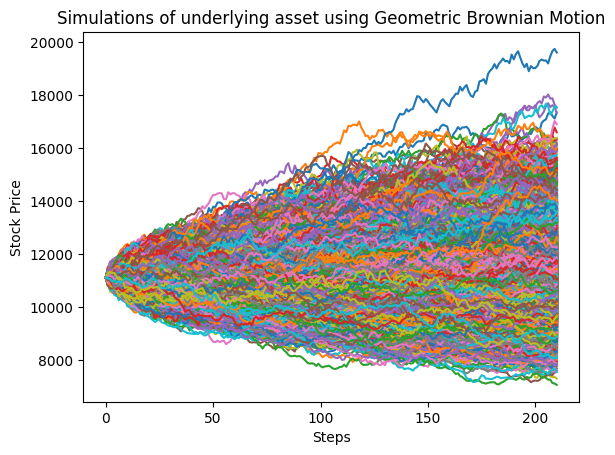

In [20]:
S = np.zeros([Nsim,N])
t = range(N)
barrier_hit_each_sim = [True] * Nsim

for i in range(Nsim):
    S[i,0]=S_0
    for j in range(N-1):
        Z = np.random.normal(0, 1)
        barrier_hit_flag = False
        
        S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
        if S[i,j+1] < barrier_price:
            barrier_hit_flag = True
    barrier_hit_each_sim[i] = barrier_hit_flag
    plt.plot(t, S[i])

# Add horizontal line for barrier price
# plt.axhline(y=barrier_price, color='r', linestyle='-')
plt.title('Simulations of underlying asset using Geometric Brownian Motion')
plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.show()


The barrier price is at $6,566.9596. Clearly, the simulation is nowhere near that point.

In [11]:
# def payoff_path(price, S_0, N):
#     final_price = np.zeros(len(price_path))
#     barrier_hit = False
#     for i in range(len(price_path)):
#         price = price_path[i]
#         if price < barrier_price:
#             barrier_hit = True
#             output_price = payoff(S_0, price, barrier_hit)
#             final_price[i] = output_price * np.exp(-r * (N - i))
#     return final_price


# final_price = np.zeros(Nsim)
# for i in range(Nsim):
#     final_price[i] = payoff(S_0, S[i, -1], barrier_hit_each_sim[i])
    


In [12]:
# final_price

In [13]:
import math
# print(get_final_price(sigma, N, S_0, r, Nsim, barrier_price))
print(get_final_price_AV(sigma, N, S_0, r, Nsim, barrier_price))
print(get_final_price_SS(sigma, N, num_bins = 5,  S_0 = 11130.44, r = 0.01 , Nsim = 50, barrier_price = 6566.9596))
plus, minus, exact = get_final_price_delta(sigma, N, S_0, r, Nsim, barrier_price, 0.01)
delta = .01


5000 5000
(np.float64(1049.8773603293837), np.float64(87.37647442095732))
(np.float64(1045.7745662387213), np.float64(71.75922549521252))
plus  = np.float64(1058.7959182045454), minus = np.float64(1044.7840326488038), exact = np.float64(1051.5506832434712), Notedelta = 0.06294398763993889


In [14]:
NoteDelta  = (plus - minus) / (2 * S_0 * delta)
NoteGamma = (plus - 2 * exact + minus) / ((S_0 * delta) ** 2)

print(NoteDelta, NoteGamma)

0.06294398763993889 3.863081245138372e-05


In [15]:
get_final_price(sigma, N, S_0, r, Nsim, barrier_price)

(np.float64(1050.2179123728497), np.float64(87.71453613144735))

In [37]:
'''
# T8.2.f ====
N1 = 100
SimHSIPre = SimGBMExact(N1, St, v, sigma, dt, Tminust)
SimNotesPre = exp(-r * Tminust) * apply(SimHSIPre, 1, NotePayoff)
c = -cov(SimNotesPre, SimHSIPre[, ncol(SimHSIPre)])/
  (St^2 * exp(2 * r * Tminust) * (exp(sigma^2 * Tminust) - 1))
SimHSICV = SimGBMExact(Nsim, St, v, sigma, dt, Tminust)
SimNotesCV = exp(-r * Tminust) * apply(SimHSICV, 1, NotePayoff) +
  c * (SimHSICV[, ncol(SimHSICV)] - St * exp(r * Tminust))

NoteCVValue = mean(SimNotesCV); NoteCVValueVar = var(SimNotesCV) / Nsim
'''


# Define parameters
r = 0.01 # Example volatility
N = 211  # Number of time steps
S_0 = 11130.44  # Initial stock price
T = 252  # Total time (e.g., 1 year)
dt = 1 / T  # Time step size
barrier_price = 6566.9596

def get_final_price_cov(sigma, N, S_0=11130.44, r=0.01, Nsim=10000, barrier_price=6566.9596):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim, N])
    S[:, 0] = S_0
    
    # Create an array to store whether the barrier was hit for each simulation
    barrier_hit_each_sim = [True] * Nsim

    for i in range(Nsim):
        S[i, 0] = S_0
        for j in range(N - 1):
            Z = np.random.normal(0, 1)
            S[i, j+1] = S[i, j] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt))
            if S[i, j+1] < barrier_price:
                barrier_hit_each_sim[i] = True  # Barrier hit in this simulation
                break  # Stop the loop if barrier price is hit

    return S[:, -1]

# First batch of simulations for control variate
first_Nsim = 1000
pre_final_price = get_final_price_cov(sigma, N, S_0, r, first_Nsim, barrier_price)
pre_discounted = np.exp(-r * N / T) * pre_final_price
c = -np.cov(pre_discounted, pre_final_price)[0][1] / (S_0 ** 2 * np.exp(2 * r * N / T) * (np.exp(sigma ** 2 * N / T) - 1))

# Second batch of simulations with control variate applied
second_Nsim = 10000
sim_cv = get_final_price_cov(sigma, N, S_0, r, second_Nsim, barrier_price)
sim_cv_discounted = np.exp(-r * N / T) * sim_cv
actual = sim_cv_discounted + c * (sim_cv - S_0 * np.exp(r * N / T))

# Output the results
print("Mean of adjusted final prices:", np.mean(actual))
print("Variance of adjusted final prices:", np.var(actual) / second_Nsim)

print(np.mean(payoff(S_0, actual, [False for i in range(second_Nsim)])))

Mean of adjusted final prices: 11130.459906580692
Variance of adjusted final prices: 0.010016481608824578
1000.001788481021
